In [17]:
# import packages
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import wandb

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/home/hubert/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [1]:
x_path = './GRU_data/combined_klek.parquet'
y_path = './GRU_data/combined_selfies.parquet'

In [5]:
# weights and biases
!wandb login

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


# Data prep

In [2]:
# alphabet of tokens for output

from selfies_tools import SELFIESVectorizer, determine_alphabet

alphabet = determine_alphabet(y_path) 
print(alphabet)

vectorizer = SELFIESVectorizer(alphabet, pad_to_len = 128)

['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[/C]', '[/N]', '[/O]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N]', '[=O]', '[=Ring1]', '[=Ring2]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@@]', '[C@H1]', '[C@]', '[C]', '[Cl]', '[F]', '[I]', '[N+1]', '[NH1]', '[N]', '[O-1]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]', '[\\C]', '[\\N]', '[\\O]', '[end]', '[nop]', '[start]']


In [6]:
from dataset import GRUDataset
dataset = GRUDataset(x_path, y_path, vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 402863
Train size: 362576
Test size: 40287


In [11]:
from torch.utils.data import DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# NN architecture

In [12]:
from gru_v1 import EncoderDecoder
#(fp_size, encoding_size, hidden_size, num_layers, output_size, dropout)

# Training loop

In [13]:
from cce import ConsciousCrossEntropy # __init__(batch size, device)

In [16]:
from example_printer import ExamplePrinter
# __init__(self, test_loader, vectorizer, device, num_examples)
# __call__(model)
printer = ExamplePrinter(test_loader, vectorizer, device)
images = printer(model)

NameError: name 'model' is not defined

In [16]:
def train(train_loader, test_loader, vectorizer, device):

    # Set hyperparameters
    EPOCHS = 30
    encoding_size = 256
    hidden_size = 256
    num_layers = 1
    learn_rate = 0.001
    dropout = 0 # dropout must be equal 0 if num_layers = 1

    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss']);
    metrics['epoch'] = epochs_range
    
    # Initialize example printer
    printer = ExamplePrinter(test_loader, vectorizer, num_examples=10)

    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display.display(fig, display_id=True)

    # Instantiating the model
    model = EncoderDecoder(
        fp_size=4860,
        encoding_size=encoding_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout).to(device)

    # Defining loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = ConsciousCrossEntropy()

    # wandb config and init
    config = dict()
    config['learning rate'] = learn_rate
    config['encoding size'] = model.encoding_size
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num epochs'] = EPOCHS
    config['Trainable parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    config['hidden size'] = model.hidden_size
    config['Number of layers'] = num_layers
    config['Dropout'] = model.decoder.dropout
    config['Batch size'] = batch_size
    wandb.init(project="encoded-to-GRU-input", config=config)

    print("Starting Training of GRU")
    print(f"Device: {device}")
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0
        model.train()
        for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X).to(device)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # calculate loss and log to wandb

        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, test_loader)
        metrics_dict = {'epoch': epoch,
                        'train_loss': avg_loss,
                        'val_loss': val_loss}
        wandb.log(metrics_dict)

        # Update metrics df
        metrics.loc[len(metrics)] = metrics_dict

        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
        
        printer(model)
        
    plt.close()
    wandb.finish()
    return model

def evaluate(model, test_loader):
    model.eval()
    criterion = ConsciousCrossEntropy()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X).to(device)
        loss = criterion(y, output)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(test_loader)
    return avg_loss

# Init and train the model

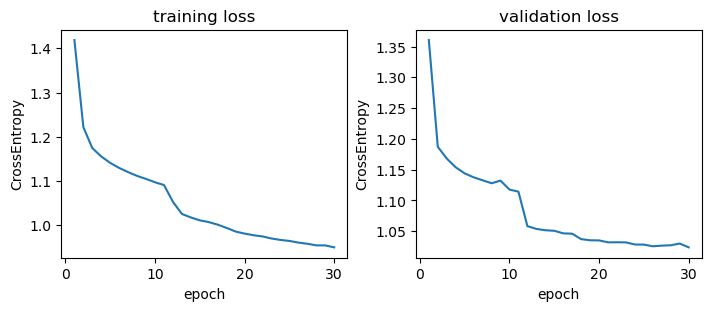

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


Starting Training of GRU
Device: cuda
Epoch: 1


100%|███████████████████████████████████████| 1416/1416 [09:27<00:00,  2.49it/s]


Predicted SELFIE:
[C][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][#Branch1][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C]

100%|███████████████████████████████████████| 1416/1416 [10:06<00:00,  2.33it/s]


Predicted SELFIE:
[C][C][C][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C]

100%|███████████████████████████████████████| 1416/1416 [10:10<00:00,  2.32it/s]


Predicted SELFIE:
[C][C][C][Branch1][Ring1][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][C][C][C][C][=C][C][=C][R

100%|███████████████████████████████████████| 1416/1416 [10:07<00:00,  2.33it/s]


Predicted SELFIE:
[C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring2][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [10:06<00:00,  2.33it/s]


Predicted SELFIE:
[C][C][C][C][=C][C][C][C][C][C][C][C][C][=C][=C][=C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [10:07<00:00,  2.33it/s]


Predicted SELFIE:
[C][C][C][C][Branch1][C][C][C][C][C][C][=C][=C][=C][C][C][C][C][C][C][C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=N][C][=C][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring2][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C]

100%|███████████████████████████████████████| 1416/1416 [10:05<00:00,  2.34it/s]


Predicted SELFIE:
[C][C][C][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][O][C][=C][C][=C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring2][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][

100%|███████████████████████████████████████| 1416/1416 [10:08<00:00,  2.33it/s]


Predicted SELFIE:
[C][C][C][Branch1][Ring1][C][C][C][C][C][=C][=C][=C][=C][=Branch1][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=N][C][=C][C][Ring1][C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Branch1][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [10:11<00:00,  2.32it/s]


Predicted SELFIE:
[C][C][C][=C][C][C][C][C][C][=C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][=C][=C][=C][C][=Branch1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][O][C][=N][C][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Branch1][C][C][Branch1][C][C][C][=C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [10:03<00:00,  2.34it/s]


Predicted SELFIE:
[C][C][C@H1][C][=Branch1][C][C][C][C][C][C][C][C][=C][=C][=C][=C][C][C][C][C][C][C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][O][C][=C][C][=C][C][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Branch1][C][C][Branch1][Branch1][C][C][C][C][=C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [09:49<00:00,  2.40it/s]


Predicted SELFIE:
[C][C][C][C][Branch1][C][C][C][C][C][C][C][C][=C][=C][=C][=C][C][C][C][C][C][C][=C][=C][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=N][C][=C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][C][C][C][C][C][C][C][C][=C][=C][=C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][Ring1][R

100%|███████████████████████████████████████| 1416/1416 [10:47<00:00,  2.19it/s]


Predicted SELFIE:
[C][C][N][C][Ring1][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][C][C][C][C][C][=C][C][=C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][Rin

100%|███████████████████████████████████████| 1416/1416 [10:56<00:00,  2.16it/s]


Predicted SELFIE:
[C][C][N][Branch1][Branch1][C][C][C][C][C][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][C][=C][C][=C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][C][C][C][C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [10:14<00:00,  2.31it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][N][Branch1][Ring1][C][C][C][C][C][=C][=C][=C][=Branch1][=C][=C][=C][=C][=C][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Ring1][Ring1][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][C][C][C][=C][C][=C][C][=C][C][=C][C][=C][C][=C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [13:34<00:00,  1.74it/s]


Predicted SELFIE:
[C][C][N][C][Branch1][C][C][C][C][C][C][C][=C][=C][=C][Ring1][=C][C][C][C][C][C][=C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][C][=N][C][=C][C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C][C][C]

100%|███████████████████████████████████████| 1416/1416 [15:56<00:00,  1.48it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][C][C][C][C][C][=C][=C][=C][Ring1][Ring1][Ring1][C][C][C][C][=C][=C][=C][=C][Ring1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Ring1][Ring1][C][C][C][C][=C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][

100%|███████████████████████████████████████| 1416/1416 [13:46<00:00,  1.71it/s]


Predicted SELFIE:
[C][C][N][C][Branch1][C][C][C][C][=C][C][=C][C][=C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C]

100%|███████████████████████████████████████| 1416/1416 [12:40<00:00,  1.86it/s]


Predicted SELFIE:
[C][C][N][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][C][=C][=C][=C][=C][=C][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][C][C][=C][C][=C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][C][=C][C][=C][C][C][

100%|███████████████████████████████████████| 1416/1416 [12:16<00:00,  1.92it/s]


Predicted SELFIE:
[C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][C][C][=C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][C][Ring1][C][C][C][C][=C][=C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][#Branch1][Ring1][=Branch1][N][C][Branch1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C][C][C][C][

100%|███████████████████████████████████████| 1416/1416 [12:13<00:00,  1.93it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][N][C][C][C][C][=C][=C][=C][=C][=C][Ring1][=C][=C][=C][=C][=C][=C][=Branch1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][C][C][C][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [12:24<00:00,  1.90it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][C][C][C][=C][C][=C][C][=C][Ring1][=C][C][=C][C][=C][C][=C][=C][=C][Ring1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][N][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][N][C][Branch1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [12:29<00:00,  1.89it/s]


Predicted SELFIE:
[C][C][C@H1][Branch1][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][C][=C][C][C][C][=C][=Branch1][=Branch1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Ring1][Ring1][Branch1][C][C][C][C][=C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][N][N][C][Branch1][=N][C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][=C][

100%|███████████████████████████████████████| 1416/1416 [12:28<00:00,  1.89it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][C][C][C][C][C][C][=C][C][=C][Ring1][=Branch1][C][C][C][=C][C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][C][C][C][=C][C][=C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][#Branch2][C][C][C][C][=C][C][=C][=C][=C][C][C][C]

100%|███████████████████████████████████████| 1416/1416 [12:29<00:00,  1.89it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][N][Branch1][Ring1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][=C][Ring1][=Branch1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][Ring1][C][=C][C][=C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1

100%|███████████████████████████████████████| 1416/1416 [12:19<00:00,  1.91it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][=C][C][C][C][C][C][=C][C][=C][C][=C][C][=C][C][=C][C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][C][Ring1][Ring1][C][C][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C][C][C][C][C][=C

100%|███████████████████████████████████████| 1416/1416 [12:13<00:00,  1.93it/s]


Predicted SELFIE:
[C][C][N][Branch1][Branch1][C][C][C][C][C][C][C][C][C][=C][C][=C][C][=C][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Branch1][C][C][C][C][=C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][=Branch1][N][C][Branch1][=N][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [12:15<00:00,  1.93it/s]


Predicted SELFIE:
[C][C][N][C][=Branch1][C][C][C][C][C][C][C][C][=C][=C][=C][Ring1][=C][C][C][=C][=C][=C][=C][Ring1][=Branch1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][N][C][=C][C][=C][C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][#Branch1][Ring1][=Branch1][N][C@H1][Branch1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [12:11<00:00,  1.94it/s]


Predicted SELFIE:
[C][C][C@H1][C][C][C][C][C][C][C][C][C][C][C][=C][C][=C][C][=C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][C][C][C][=C][C][=C][Branch1][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][N][C][Branch1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C

100%|███████████████████████████████████████| 1416/1416 [12:02<00:00,  1.96it/s]


Predicted SELFIE:
[C][C][C@H1][C][=Branch1][C][C][N][Branch1][C][C][C][C][=C][C][=C][C][=C][C][=C][C][=C][C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][C][Ring1][Ring1][C][C][=C][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][N][C][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][C][C][C][C][

100%|███████████████████████████████████████| 1416/1416 [12:06<00:00,  1.95it/s]


Predicted SELFIE:
[C][C][C@H1][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][C][=C][=C][=C][=C][=C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][C@H1][C][S][/C][=Branch2][Ring1][Ring1][=N][\C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Ring2][Ring1][Ring1]
------------------------------------------------------------ 

Predicted SELFIE:
[C][C][Branch1][C][C][N][C][=C][C][=C][Ring1][Ring1][C][=C][C][C][=C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][Branch1][C][C][N][C][=N][C][=C][Branch2][Ring1][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][F][Branch1][C][F][F][N][=C][Branch1][Branch1][N][C][C][O][N][=C][Ring2][Ring1][Branch1][Ring2][Ring1][Branch2]
------------------------------------------------------------ 

Predicted SELFIE:
[O][=C][Branch1][Ring1][Ring1][N][C@H1][Branch1][#Branch2][C][C][=C][C][=C][=C][Ring1][=Branch1][=Branch1][C][C][C][C][C]

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.9501
val_loss,1.02365


In [17]:
model = train(train_loader, test_loader, vectorizer, device)

In [1]:
# save model
torch.save(model.state_dict(), './GRU_data/xxx')

NameError: name 'torch' is not defined